## COMP 341: Practical Machine Learning
## Homework Assignment 6: First Deep Learning Model
### Due: Thursday, November 15 at 11:59pm on Gradescope

This assignment will walkthrough some of the fundamentals of PyTorch as we building a deep learning classifier to identify items of clothing from black and white images. The dataset that we will be using, [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist), is often used for benchmarking and is inspired by the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits.

As always, fill in missing code following `# TODO:` comments or `####### YOUR CODE HERE ########` blocks and be sure to answer the short answer questions marked with `[WRITE YOUR ANSWER HERE]` in the text.

All code in this notebook will be run sequentially so make sure things work in order! Be sure to also use good coding practices (e.g., logical variable names, comments as needed, etc), and make plots that are clear and legible.

For this assignment, there will be **15 points** allocated for general coding points:
* **10 points** for coding style
* **5 points** for code flow (accurate results when everything is run sequentially)

### Part 0: Setup
First, we need to import the necessary libraries for this assignment.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Add additional modules/libraries to import here (rather than wherever you first use them).

In [ ]:
# additional modules / libraries to import

from torch.utils.data import DataLoader
from collections import defaultdict
from plotnine import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


Make sure we are using the latest torch version (PyTorch 1.12.1) and check if we have GPUs available (cu or cuda vs cpu).

In [ ]:
torch.__version__

'1.12.1+cu113'

We would preferably like to also take advantage of any GPU resources to speed up our training. To this end, in Colab, you can click on the RAM / Disk monitoring bars towards the upper right corner of your Colab instance. Then in the menu that appears, click "Change runtime type" and select "GPU" under "Hardware accelerator." Let's check if the GPU is indeed detected. Note that whis code snippet will by default assume we are using CPU resources unless it can detect GPUs available.

In [ ]:
device = "cpu"
if (torch.cuda.is_available()):
  device = "cuda"
print("device: " + device)

device: cuda


If `device` is now `cuda`, that means GPUs have been successfully enabled. The `device` string simply will be used in a few key parts of the code to signal to PyTorch whether or not to move the model / weights etc to the GPU, if available. Using GPUs for this assignment is optional (though doing so will allow you to train faster).

PyTorch provides convenient functionality to download and load Fashion-MNIST as a `Dataset` that can be used with `DataLoader`. Here, we load the data directly using PyTorch, which will automatically download the data into your colab folder (and redownload as necessary).

In [ ]:
fm_data_train = torchvision.datasets.FashionMNIST('./data', download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
fm_data_valid = torchvision.datasets.FashionMNIST('./data', download=True, train=False,
                                                  transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# based on the label definitions given by the original dataset
# https://github.com/zalandoresearch/fashion-mnist#labels
# we have provided a convenient function to get the actual labels
# corresponding to each numeric label in the dataset
def label_name(label):
  label_mapping = {
      0: "T-shirt/Top",
      1: "Trouser",
      2: "Pullover",
      3: "Dress",
      4: "Coat",
      5: "Sandal",
      6: "Shirt",
      7: "Sneaker",
      8: "Bag",
      9: "Ankle Boot"
      }
  label_num = (label.item() if type(label) == torch.Tensor else label)
  return label_mapping[label_num]

We can now loop through a couple of the first few images in our dataset! Note that we enlarge the image simply for easy visualization purposes. You are free to play around with this more if you would like to see examples of the images you will be developing a method to classify.

label id: 9 name: Ankle Boot


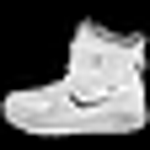

label id: 0 name: T-shirt/Top


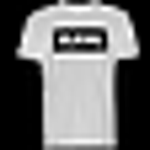

label id: 0 name: T-shirt/Top


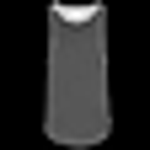

label id: 3 name: Dress


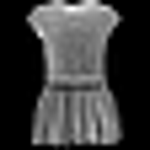

In [ ]:
tens_to_img = transforms.ToPILImage()
for i in range(4):
  print('label id:', fm_data_train[i][1], 'name:', label_name(fm_data_train[i][1]))
  display(tens_to_img(fm_data_train[i][0]).resize((150,150)))

### Part 1: Load and Explore the Data [12 pts]

Let's take a quick look at the data and get a sense of simple information, and also set up our first `DataLoader`.

In [ ]:
# TODO: how many observations are there in your training and validation sets?
print("training: " + str(len(fm_data_train)))
print("validation: " + str(len(fm_data_valid)))

training: 60000
validation: 10000


In [ ]:
# TODO: make data loaders for the training and validation datasets
# that we loaded above; for now, start with a batch size of 1
batch_size = 1

train_dataloader = DataLoader(fm_data_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(fm_data_valid, batch_size=batch_size, shuffle=True)

Based on the data description, we know that there are 10 labels (with mappings between number and actual category provided by our `label_name` method). Let's use the DataLoaders that we just made to count up the number of observations we have per label.

In [ ]:
# TODO: loop through the entire dataset using the DataLoaders you constructed earlier
# and count how many observations we have per label (in both training and validation sets)
# show the results using the label name (not simply the number representation)

labels = defaultdict(int)

for dl in [train_dataloader, valid_dataloader]:
  for i, batch in enumerate(dl):
    label = label_name(batch[1])
    labels[label] += 1

print(labels)

defaultdict(<class 'int'>, {'Sneaker': 7000, 'Ankle Boot': 7000, 'Sandal': 7000, 'Bag': 7000, 'Dress': 7000, 'Coat': 7000, 'T-shirt/Top': 7000, 'Trouser': 7000, 'Pullover': 7000, 'Shirt': 7000})


### Part 2: Define the Model [37 pts]

In this section we will construct our model using CNNs with a multilayer perceptron at the end for classification. As the data description shows (and we could also verify easily), each image is grayscale, 28 x 28 pixels.

We have provided a scaffold for you to built up a CNN with 2 convolution layers and 3 fully connected layers. Note that we described the model specification (and associated hyperparameters) you need to choose in the `__init__` method, but you can feel free to implement some parts of the specification in the `forward` method if you would prefer (e.g., activation functions). In addition, for layers like the pooling layer that are identical and have no associated parameters, you are free to reuse the same one.

As usual, fill in code when there is a `TODO`; we have provided more scaffolding code / methods than usual here to help guide you along. Unless specified, do not change those portions of the code.

In [ ]:
# first model attempt
class StylishNN(nn.Module):
  def __init__(self, num_classes=10):
    # TODO: inherit from nn.Module
    super().__init__()
    # TODO: add a first convolution layer together with a ReLU activation function
    # for this first convolution layer, we want to apply 12 filters, where each
    # filter is 5x5, taking strides of 1, and padded to maintain the original image size
    # follow up on this convolution with max pooling with a 2x2 filter and stride 2
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(1, 12, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # TODO: add a second convolution layer that expands the number of filters to 32
    # the filters will still be 5x5 and taking strides of 1, but this time, use a 1 pixel padding instead
    # follow up on this convolution with max pooling again with a 2x2 filter and stride 2 and a ReLU activation function
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(12, 32, kernel_size=5, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # TODO: for the classification portion of this neural network, make 3 fully connected layers
    # you will need to calculate what the current dimensions of your tensors are after convolution
    # and pooling, as you the fully connected layers will use the flattened values
    # with that number as your initial input, here are the number of neurons for each layer, together
    # with which activation function we would like to use
    self.flat = nn.Flatten()
    self.classify = nn.Sequential(
      # fully connected layer 1: 600 neurons, ReLU activation
      nn.Linear(32*6*6, 600),
      nn.ReLU(),
      # fully connected layer 2: 120 neurons, ReLU activation
      nn.Linear(600, 120),
      nn.ReLU(),
      # fully connected layer 3 (output layer): num_classes neurons, no additional activation function,
      nn.Linear(120, 10)
    )
    # use the log(softmax) of these values to correspond to a probability for each class
    self.logsoftmax = nn.LogSoftmax()


  def forward(self, x):
    # TODO: forward pass for the convolution and pooling layers
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    # TODO: flatten parameters into 1 dimension before passing them
    # on to our fully connected layers
    x = self.flat(x)
    # TODO: forward pass for the fully connected layers
    x = self.classify(x)
    # TODO: return the log(softmax) predictions for each class
    return self.logsoftmax(x)

### Part 3: Model Training [16 pts]

Now that we've constructed our model in part 2, it is time to train. Instead of stochastic gradient descent, we would prefer to use mini-batch gradient descent. For the next parts, set up your `DataLoader`s to use batch sizes of 64.

In [ ]:
# TODO: make data loaders for the training and validation datasets
# with a batch size of 64; remember that we want to randomize the order that we see our data!
batch_size = 64

train_loader = DataLoader(fm_data_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(fm_data_valid, batch_size=batch_size, shuffle=True)

In [ ]:
# TODO: fill in the steps that we want to take within the training loop
# (this function will run once per epoch)
# we have provided some helper code for logging progress

def train(model, train_loader, opt, epoch, verbose=False):
  if verbose:
    print("starting epoch", epoch)

  train_loss = 0

  for i, (image, label) in enumerate(train_loader):
    image, label = image.to(device), label.to(device) # uses GPUs if possible

    # TODO: a) forward pass
    ypred_batch = model(image)
    # TODO: b) calculate loss
    loss = loss_fn(ypred_batch, label)
    # TODO: c) backward pass
    loss.backward()
    # TODO: d) update weight estimates
    opt.step()
    # TODO: e) reset gradients to zero
    opt.zero_grad()
    # we are tracking the sum of losses to calculate the average training loss for this epoch
    train_loss += loss.item()

    # when verbose is on, we will show how the loss is changing across batches within one epoch
    if verbose and ((i % 100) == 0):
      print('training [epoch {}: {}/{} ({:.0f}%)] loss: {:.6f}'.format(
          epoch, i * len(image), len(train_loader.dataset),
          100. * i / len(train_loader), loss.item()))

  avg_tl = train_loss / (i+1)
  print('epoch {} avg training loss: {:.6f}'.format(epoch, avg_tl))
  return avg_tl

In [ ]:
# we have provided the below code for reporting loss and accuracy
# on your validation set, so simply run this snippet without any changes

actual_lst = []
pred_lst = []

def valid(model, valid_loader, actual, predict, epoch):
  valid_loss = 0
  correct = 0
  with torch.no_grad(): # for validation, we do not need to update gradients
    for i, (image, label) in enumerate(valid_loader):

      # for confusion matrix
      if (epoch == 15):
        actual.append(label)

      image, label = image.to(device), label.to(device)

      # get the model prediction
      pred = model(image)

      # update our running tally of the validation loss
      valid_loss += loss_fn(pred, label).item()

      # calculate the accuracy for this batch
      _, pred = torch.max(pred.data, 1)

      # for confusion matrix
      if (epoch == 15):
        predict.append(pred)

      correct += torch.sum(label==pred).item()

  # get the loss for the epoch
  avg_vl = valid_loss / (i+1)
  print('avg validation loss: {:.6f}, accuracy: {}/{} (({:.0f}%))'.format(
      avg_vl, correct, len(valid_loader.dataset),
      100. * correct / len(valid_loader.dataset)))

  return avg_vl

In [ ]:
# we can now initialize the model you designed above
# and optionally put it on the GPU if we have enabled it
# remember to rerun this if you want to re-initialize your parameters!
# (otherwise, the model will simply keep updating the previous parameters)
model = StylishNN().to(device)

# TODO: initialize an SGD optimizer with learning rate 0.01
opt = torch.optim.SGD(model.parameters(), lr=0.01)
# TODO: initialize cross entropy as your loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# now that you have defined your model and set up the training loop
# we can run through 15 epochs and see how our training and validation
# losses change over time (you can just run this code directly)
# note that we have turned on verbose here to better see intermediate progress
# but if the output is overwhelming, you can feel free to turn it off
epoch_list = []
train_loss = []
valid_loss = []

epochs = 15
for e in range(1, epochs+1):
  epoch_list.append(e)
  train_loss.append(train(model, train_loader, opt, e, verbose=True))
  valid_loss.append(valid(model, valid_loader, actual_lst, pred_lst, e))

starting epoch 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


training [epoch 1: 0/60000 (0%)] loss: 2.304908
training [epoch 1: 6400/60000 (11%)] loss: 2.299676
training [epoch 1: 12800/60000 (21%)] loss: 2.286234
training [epoch 1: 19200/60000 (32%)] loss: 2.268152
training [epoch 1: 25600/60000 (43%)] loss: 2.227967
training [epoch 1: 32000/60000 (53%)] loss: 1.841817
training [epoch 1: 38400/60000 (64%)] loss: 1.072510
training [epoch 1: 44800/60000 (75%)] loss: 1.155559
training [epoch 1: 51200/60000 (85%)] loss: 0.966138
training [epoch 1: 57600/60000 (96%)] loss: 0.763530
epoch 1 avg training loss: 1.690852
avg validation loss: 0.892944, accuracy: 6259/10000 ((63%))
starting epoch 2
training [epoch 2: 0/60000 (0%)] loss: 0.884950
training [epoch 2: 6400/60000 (11%)] loss: 0.682798
training [epoch 2: 12800/60000 (21%)] loss: 0.880500
training [epoch 2: 19200/60000 (32%)] loss: 0.687331
training [epoch 2: 25600/60000 (43%)] loss: 0.777946
training [epoch 2: 32000/60000 (53%)] loss: 0.628720
training [epoch 2: 38400/60000 (64%)] loss: 0.64041

### Part 4: Checking Performance [20 pts]

In this section we will plot training and test over the different epochs as well as look for any confusion between classes.

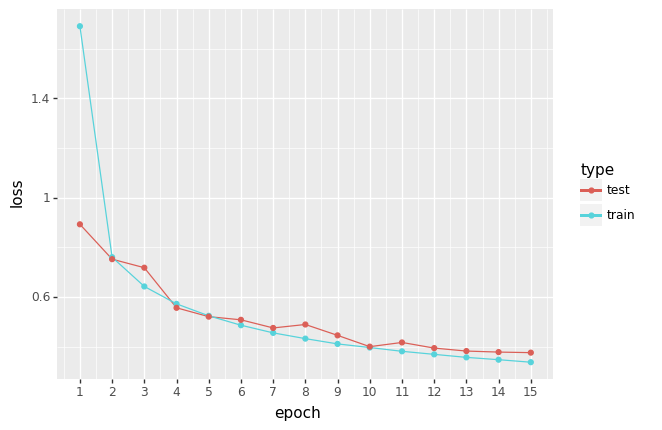

<ggplot: (8735799350741)>

In [ ]:
# TODO: as we trained our model, we captured the epoch,
# average loss for the training and validation sets in
# epoch_list, train_loss, and valid_loss
# use these to plot the loss vs epochs for the training and test set

train_df = pd.DataFrame({'epoch':epoch_list, 'loss':train_loss})
test_df = pd.DataFrame({'epoch':epoch_list, 'loss':valid_loss})

train_df['type'] = 'train'
test_df['type'] = 'test'

df = pd.concat([train_df, test_df])
(ggplot(df, aes(x='epoch', y='loss', color='type'))
 + geom_line()
 + geom_point()
 + scale_x_continuous(breaks = list(range(0, 16))))

**Short Answer Question:** Based on your plot, does it seem like our model converged within 15 epochs? Would you add more epochs? Or stop earlier? Explain.

`[WRITE YOUR ANSWER HERE]`

It seems that the model has not converged yet because the loss for the test data is still trending down, even though it is fluctuating. So, I would add more epochs

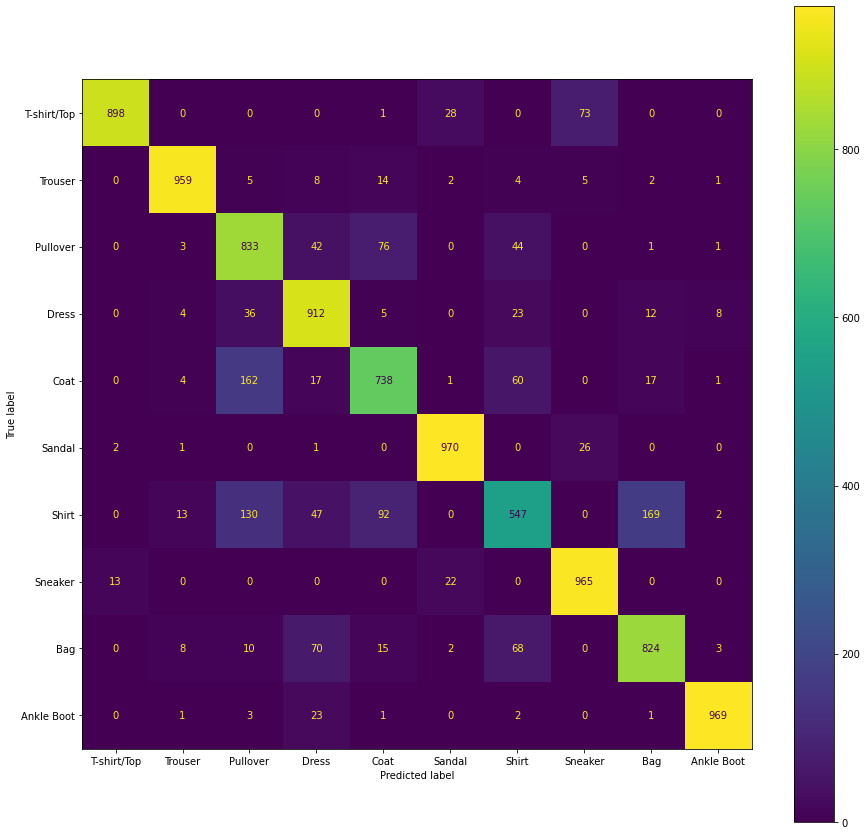

In [ ]:
# TODO: use sklearn's convenient confusionmatrix and ConfusionMatrixDisplay
# methods to calculate and visualize the confusion matrix for your
# current predictions, making sure to display the human-readable
# class labels (instead of 0-9)

actual = []
pred = []
labels = [
  "T-shirt/Top",
  "Trouser",
  "Pullover",
  "Dress",
  "Coat",
  "Sandal",
  "Shirt",
  "Sneaker",
  "Bag",
  "Ankle Boot"
]

for batch in actual_lst: # calculated on the last epoch of the valid function
  flat = torch.flatten(batch)
  flat = flat.tolist()
  for elem in flat:
    actual.append(label_name(elem))


for batch in pred_lst: # calculated on the last epoch of the valid function
  flat = torch.flatten(batch)
  flat = flat.tolist()
  for elem in flat:
    pred.append(label_name(elem))

fig, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(actual, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax)
plt.show()

**Short Answer Question:** Does our model have any trouble distinguishing any items of clothing? If so, which ones does it tend to mixed up?


`[WRITE YOUR ANSWER HERE]`

The items of clothing that gets mixed up are:

Coat and shirt,
coat and pullover,
pullover and shirt,
bag and shirt

**Short Answer Question:** In this homework we tried one model architecture (a CNN with 2 convolutions and 3 fully connected layers) and achieved reasonable performance on the validation set. Could we instead use the output of the CNN with a classical machine learning algorithm? Explain your answer.

`[WRITE YOUR ANSWER HERE]`

Yes. We can train a classical machine learning algorithm using the output of CNN. The output of CNN is basically like a feature of what we are used to.

### Bonus: Turning more Knobs [Extra Credit: up to 10 points]

We achieved reasonable prediction performance but only explored how performance might change with the number of epochs here. As we discussed in class, there are many more knobs we can turn (e.g., network initialization, learning rate, activation function, regularization, changing the number/types of layers, etc etc)!

Here, you can explore the impact of adjusting other hyperparameters for this same dataset.

2 extra credit points will be allotted for each hyperparameter that is found that improves either overall performance or the speed at which performance converges (measured in epochs). (Remember to set a manual random seed and use the same dataset splits etc for model comparison purposes.)

In [ ]:
# TODO: neural network playground

## To Submit
Download the notebook from Colab as a `.ipynb` notebook (`File > Download > Download .ipynb`) and upload it to the corresponding Gradescope assignment. Your assignment should be named `comp341-hw6.ipynb`.  